In [144]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import control.matlab as cm
import sympy as sy

# Preparations
Continuous time state space system 
\begin{align}
\dot{x} &= Ax + Bu\\
y &= Cx,
\end{align}
with
\begin{align}
A &= \begin{bmatrix} 2 & -2\\ 1 & 0 \end{bmatrix}\\
B &= \begin{bmatrix} 1\\0\end{bmatrix}\\
C &= \begin{bmatrix} 0 & 1\end{bmatrix}
\end{align}
Want closed loop system with poles in $p_{1,2} = -2 \pm j$
using statefeedback $u = Lx + mr$.

The sampling time is $h=0.1 s$. 
## Preparation exercise 1
Determine $L$ so that eigenvalues of $A+BL$ as specified

Note that the system is on controllable form. It thus have the characteristic equation
\begin{equation}
s^2 -2s + 2.
\end{equation}
With state feedback, the system is still on controllable form:
\begin{equation}
A+BL = \begin{bmatrix} 2+l_1 & -2+l_2\\1 & 0 \end{bmatrix}
\end{equation}
with characteristic equation
\begin{equation}
s^2 + (-2-l_1)s + (2-l_2).
\end{equation}
The desired characteristic equation is 
\begin{equation}
(s+2+i)(s+2-i) = s^2 + 4s + 5.
\end{equation}
Identifying the coefficients gives 
\begin{align}
l_1 &= -6\\
l_2 &= -3
\end{align}

In [145]:
A = np.array([[2, -2], [1, 0]])
B = np.array([[1],[0]])
C = np.array([[0,1]])
D = np.array([[0]])

In [146]:
As = sy.Matrix(A)
Bs = sy.Matrix(B)
Cs = sy.Matrix(C)
l1,l2 = sy.symbols("l1 l2")
L = sy.Matrix([[l1, l2]])
Ac = A+B*L
pc = Ac.eigenvals()
pc

{l1/2 - sqrt(l1**2 + 4*l1 + 4*l2 - 4)/2 + 1: 1,
 l1/2 + sqrt(l1**2 + 4*l1 + 4*l2 - 4)/2 + 1: 1}

In [147]:
l1l2 = sy.solve([l1/2+1+2, l1**2+4*l1+4*l2-4 + 4], (l1,l2)) 
L = np.array([float(l) for l in l1l2[0]])
L

array([-6., -3.])

In [148]:
Ac2 = Ac.subs(l1,-6).subs(l2,-3)
Ac2.eigenvals()

{-2 - I: 1, -2 + I: 1}

## Preparations exercise 2
Derive a discrete time representation with sampling time $h=0.1$
Solution to the continuous time system starting from a known state $x(0)$ at time $t=0$ is given by 
\begin{equation}
x(t) = \mathrm{e}^{At}x(0) + \int_0^{t}\mathrm{e}^{A(t-\tau)}Bu(\tau)d\tau.
\end{equation}
Without loss of generality, we can assume $t$ to denote the (continous) time elapsed since the last sampling instant $k$. Assuming that $u$ is constant between sampling instants  $u(t)=u(0)$ for $t<h$, we get the solution at time $t=h$
\begin{equation}
x(h) = \mathrm{e}^{Ah}x(0) + \Big(\int_0^{h}\mathrm{e}^{A(h-\tau)}Bd\tau\Big) u(0) = \Phi(h)x(0) + \Gamma(h)u(0).
\end{equation}
See Åstrom & Wittenmark 3.2.
We can for instance compute by series expansion
\begin{equation}
\Psi = \int_0^h\mathrm{e}^{A\tau}d\tau = Ih + \frac{Ah^2}{2!} + \frac{A^2h^3}{3!} + \cdots
\end{equation}
\begin{align}
\Phi &= I + A\Psi\\
\Gamma &= \Psi B
\end{align}

In [149]:
tol = 1e-12
h = 0.1
hp = h
term = np.identity(2)*h
Psi = term
k=1.0
while np.linalg.norm(term) > tol:
    k += 1.0
    term = np.dot(A,term)*h/k
    Psi += term
    hp *= h

print k
Phi = np.identity(2) + np.dot(A,Psi)
Gamma = np.dot(Psi, B)

print Phi
print Gamma

9.0
[[ 1.20998266 -0.22066598]
 [ 0.11033299  0.98931668]]
[[ 0.11033299]
 [ 0.00534166]]


## Preparation exercise 3
Determine discrete time poles that correspond to the continuous time ones. 

The mapping from continuous to discrete time poles is given by (3.54) in Å&W section 3.6
\begin{equation}
\lambda_i(\Phi) = \mathrm{e}^{\lambda_i(A)h}
\end{equation}


In [150]:
z1 = np.exp((-2-1j)*h)
z2 = np.exp((-2+1j)*h)
print z1
print z2

(0.814640509554-0.0817366883936j)
(0.814640509554+0.0817366883936j)


Find the control law $L$ for the discrete time case using Ackermans formula
\begin{equation}
L = \begin{bmatrix} 0  & \cdots & 0 & 1\end{bmatrix} W_c^{-1}P(\Phi),
\end{equation}
where $W_c$ is the controllability matrix for the system, i.e.
\begin{equation}
W_c = \begin{bmatrix} \Gamma & \Phi\Gamma & \cdots & \Phi^{n-1}\Gamma \end{bmatrix},
\end{equation}
and $P(\Phi)$ is the characteristic equation of the closed loop system with $\Phi$ as argument. That is,
\begin{equation}
P(\Phi) = \Phi^n + p_1\Phi^{n-1} + \cdots + p_nI,
\end{equation}
with
\begin{equation}
P(z) = z^n + p_1z^{n-1} + \cdots + p_n = 0
\end{equation}
giving the desired poles of the closed loop system.

In [151]:
p1 = -z1-z2
p2 = z1*z2
Wc = np.hstack((Gamma, np.dot(Phi,Gamma)))
P = np.dot(Phi, Phi) + p1*Phi + p2*np.identity(2)
WinvP = np.dot(np.linalg.inv(Wc), P)
Ld = -np.real(WinvP[-1,:])
Ld.shape = (1,2)
print Ld

Phic = Phi + np.dot(Gamma, Ld)
np.linalg.eig(Phic)

[[-5.08339449 -1.71336368]]


(array([ 0.81464051+0.08173669j,  0.81464051-0.08173669j]),
 array([[ 0.91172384+0.j        ,  0.91172384-0.j        ],
        [-0.36834206-0.18188944j, -0.36834206+0.18188944j]]))

# Computer experiments
## Computer exercise 1
Controller design for the continuous time system

In [152]:
sys_c = cm.ss(A,B,C,D)
sys_d = cm.ss(Phi, Gamma, C, D, h)
Lc = -cm.place(A, B, [-2+1j, -2-1j])
print (L-Lc)
print L
print Lc
print np.linalg.eig(A+np.dot(B,Lc))

[[ -1.77635684e-15   1.77635684e-15]]
[-6. -3.]
[[-6. -3.]]
(array([-2.+1.j, -2.-1.j]), array([[ 0.91287093+0.j        ,  0.91287093-0.j        ],
       [-0.36514837-0.18257419j, -0.36514837+0.18257419j]]))


## Computer exercise 2
Controller design for the discrete time system

In [153]:
sys_d2 = cm.c2d(sys_c, h)
print sys_d
print sys_d2
Ld2 = -cm.place(Phi,Gamma,[z1,z2])
print (Ld-Ld2)
print Ld
print Ld2
print np.linalg.eig(Phi+np.dot(Gamma,Ld2))
print z1

A = [[ 1.20998266 -0.22066598]
 [ 0.11033299  0.98931668]]

B = [[ 0.11033299]
 [ 0.00534166]]

C = [[0 1]]

D = [[0]]

dt = 0.1

A = [[ 1.20998266 -0.22066598]
 [ 0.11033299  0.98931668]]

B = [[ 0.11033299]
 [ 0.00534166]]

C = [[0 1]]

D = [[0]]

dt = 0.1

[[ -8.88178420e-16  -3.10862447e-15]]
[[-5.08339449 -1.71336368]]
[[-5.08339449 -1.71336368]]
(array([ 0.81464051+0.08173669j,  0.81464051-0.08173669j]), array([[ 0.91172384+0.j        ,  0.91172384-0.j        ],
       [-0.36834206-0.18188944j, -0.36834206+0.18188944j]]))
(0.814640509554-0.0817366883936j)


## Computer exercise 3 Simulation
Create closed loop continuous time system with unit dc gain

In [154]:
Ac = A + np.dot(B,Lc)
sys_cl = cm.ss(Ac, B, C, D)
dcg = cm.dcgain(sys_cl)
m = 1.0/dcg[0,0]
sys_cl = sys_cl*m
print cm.dcgain(sys_cl)


[[ 1.]]


Discrete system with same feedback gain as continuous time system, and with correct feedback gain 

In [155]:
sys_cl_d1 = cm.ss(Phi+np.dot(Gamma,Lc), Gamma*m, C, D, h )
sys_cl_d2 = cm.ss(Phi+np.dot(Gamma,Ld), Gamma, C, D, h )
dcg_d = np.dot(np.dot(C, np.linalg.inv(np.identity(2)-sys_cl_d2.A)), sys_cl_d2.B)
md = 1.0/dcg_d[0,0]
sys_cl_d2 = md * sys_cl_d2


Simulate the three systems

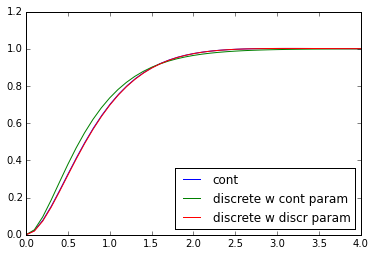

In [156]:
Tc = np.linspace(0,10,100)
Td = h*np.arange(100)
(yc, tc) = cm.step(sys_cl, Tc)
(yd1, td1) = cm.step(sys_cl_d1, Td)
(yd2, td2) = cm.step(sys_cl_d2, Td)
yy1 = np.ravel(yd1)
yy2 = np.ravel(yd2)

plt.plot(tc,yc)
plt.plot(td1,np.ravel(yd1)/1)
plt.plot(td2,np.ravel(yd2)/yy2[-1])
plt.xlim([0, 4])
plt.legend(["cont", "discrete w cont param", "discrete w discr param"], loc="lower right")


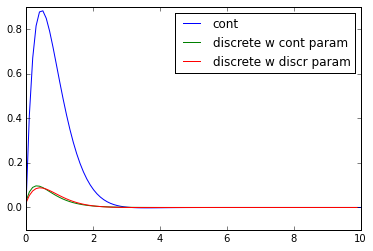

In [157]:
Tc = np.linspace(0,10,100)
Td = h*np.arange(100)
(yc, tc) = cm.impulse(sys_cl, Tc)
(yd1, td1) = cm.impulse(sys_cl_d1, Td)
(yd2, td2) = cm.impulse(sys_cl_d2, Td)

plt.plot(tc,yc)
plt.plot(td1,np.ravel(yd1))
plt.plot(td2,np.ravel(yd2))
plt.legend(["cont", "discrete w cont param", "discrete w discr param"], loc="upper right")


# Effect of sampling interval
Try different values of sampling time

[[-5.89648182 -2.85234898]]
4.85234897505
[[ 0.00025591]]
[[-5.08339449 -1.71336368]]
3.71336368494
[[ 0.0316319]]
[[-4.37906119 -0.77164543]]
2.7716454345
[[ 0.16072844]]
[[-3.3826708   0.43249366]]
1.56750633762
[[ 1.05020656]]
[[-2.24690972  1.46742321]]
0.532576792926
[[ 11.79796189]]
[[-1.12537829  1.92223294]]
0.0777670580072
[[ 461.63059112]]


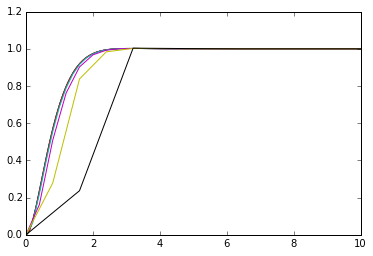

In [158]:
(yc, tc) = cm.step(sys_cl, Tc)
plt.plot(tc,yc)
for hh in [0.01, 0.1, 0.2, 0.4, 0.8, 1.6]:
    sys_d2 = cm.c2d(sys_c, hh)
    z1 = np.exp((-2-1j)*hh)
    z2 = np.exp((-2+1j)*hh)
    F = sys_d2.A
    G = sys_d2.B
    
    Ld2 = -cm.place(F,G,[z1,z2])
    print Ld2
    sys_cl_d = cm.ss(F+np.dot(G,Ld2), G, C, D, hh )
    # Find dc gain of the discrete time system (See below)
    dcg_d = np.dot(np.dot(C, np.linalg.inv(np.identity(2)-sys_cl_d.A)), sys_cl_d.B)
    md = 1.0/dcg_d[0,0]
    sys_cl_d = md * sys_cl_d
    print md
    print cm.dcgain(sys_cl_d)
    Td = np.arange(1000)*hh
    (yd1, td1) = cm.step(sys_cl_d, Td)
    yy = np.ravel(yd1)
    #plt.plot(td1,yy/yy[-1])
    plt.plot(td1,yy)
    plt.xlim([0, 10])

# DC gain for discrete system
In steady state with step input we have $x(k+1) = x(k)$
\begin{equation}
x(k) = \Phi x(k) + m\Gamma
\end{equation}
Hence,
\begin{equation}
x(\infty) = m(1-\Phi)^{-1}\Gamma,
\end{equation}
and so
\begin{equation}
y(\infty) = mC(1-\Phi)^{-1}\Gamma.
\end{equation}
For this to be equal to 1, we must have
\begin{equation}
m = \frac{1}{C(1-\Phi)^{-1}\Gamma}.
\end{equation}
